In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

uniqe_leagues = ['Southkorea'] #write names with Capital!
home_team, away_team = 'Seoul', 'Gwangju' #check soccerstats for correct spelling
final =  pd.DataFrame()
next_matches = pd.DataFrame()

for i in uniqe_leagues:
    URL = "https://www.soccerstats.com/results.asp?league=" + i + "&pmtype=bydate"
    page = requests.get(URL)
    liqa = i
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="btable")
    sth = results.find_all("tr", class_="odd")
    sth


    date, league, home, away, ft, ht = [], [], [], [], [],[]
    for i in sth:
        date.append(i.find_all("td", align = 'right')[0].get_text(strip=True))
        league.append(liqa.capitalize())
        home.append(i.find_all("td", align = 'right')[1].get_text(strip=True))
        away.append(i.find("td", align = "left").get_text(strip = True))
        ft.append(i.find_all("td", align = 'center')[0].get_text(strip = True))
        try:
            ht.append(i.find_all("td", align = 'center')[2].get_text(strip = True))
        except IndexError as e:
            ht.append('NA')#print("Last output before error occurred:", i.find_all("td", align = 'center'))

    data = {'Date': date, 'League': league,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

# Replace empty strings with NaN
    next_df = df[(df['HT'] == '')]
    next_matches = pd.concat([next_matches, next_df], ignore_index = True)
    df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
    df_cleaned = df.dropna()

#For Half-Time Results
    hthg, htag = [], []
    for i in df_cleaned['HT']:
        if i == 'NA':
            hthg.append('NA')
            htag.append('NA')
        elif i == '+' or i == '-':
            hthg.append('NA')
            htag.append('NA')
        else:
            try:
                hthg.append(int(i[1]))
                htag.append(int(i[3]))
            except IndexError as e:
                print("Last output before error occurred:", i)



#For Full-Time Results
    hg, ag, tg = [], [], []
    for i in df_cleaned['FT']:
        if len(i) < 5 or ':' in i:
            hg.append('NA')
            ag.append('NA')
            tg.append('NA')
        else:
            try:
                hghg = int(i.split(' - ')[0])
                hg.append(hghg)
                agag = int(i.split(' - ')[1])
                ag.append(agag)
                tg.append(hghg + agag)
            except:
                print(hghg + agag)

    
    df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
    df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
    df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']
    # Convert all relevant columns to numeric, coercing errors to np.nan
    for col in ['FTHG', 'FTAG', 'FTTG', 'HTHG', 'HTAG', 'HTTG']:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
    
    final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']
# Apply logic to calculate points
final["HPS"] = np.where(final["FTHG"] > final["FTAG"], 3,
                        np.where(final["FTHG"] == final["FTAG"], 1, 0))

final["APS"] = np.where(final["FTAG"] > final["FTHG"], 3,
                        np.where(final["FTHG"] == final["FTAG"], 1, 0))

combined_df = pd.concat([final.head(), final.tail()])
combined_df

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,HPS,APS
0,Sat 15 Feb,Southkorea,Pohang Steelers,Daejeon Citizen,0 - 3,(0-1),0,3,3,0,1,1,0,3
1,Sat 15 Feb,Southkorea,Jeju Utd,Seoul,2 - 0,(1-0),2,0,2,1,0,1,3,0
2,Sat 15 Feb,Southkorea,Gwangju,Suwon City,0 - 0,(0-0),0,0,0,0,0,0,1,1
3,Sun 16 Feb,Southkorea,Ulsan,Anyang,0 - 1,(0-0),0,1,1,0,0,0,0,3
4,Sun 16 Feb,Southkorea,Daegu,Gangwon,2 - 1,(0-1),2,1,3,0,1,1,3,0
173,Sun 14 Sep,Southkorea,Suwon City,Gwangju,2 - 4,(2-2),2,4,6,2,2,4,0,3
174,Sat 20 Sep,Southkorea,Jeonbuk,Gimcheon Sangmu,1 - 2,(0-2),1,2,3,0,2,2,0,3
175,Sat 20 Sep,Southkorea,Daejeon Citizen,Daegu,3 - 2,(2-0),3,2,5,2,0,2,3,0
176,Sun 21 Sep,Southkorea,Suwon City,Gangwon,1 - 0,(0-0),1,0,1,0,0,0,3,0
177,Sun 21 Sep,Southkorea,Ulsan,Anyang,0 - 0,(0-0),0,0,0,0,0,0,1,1


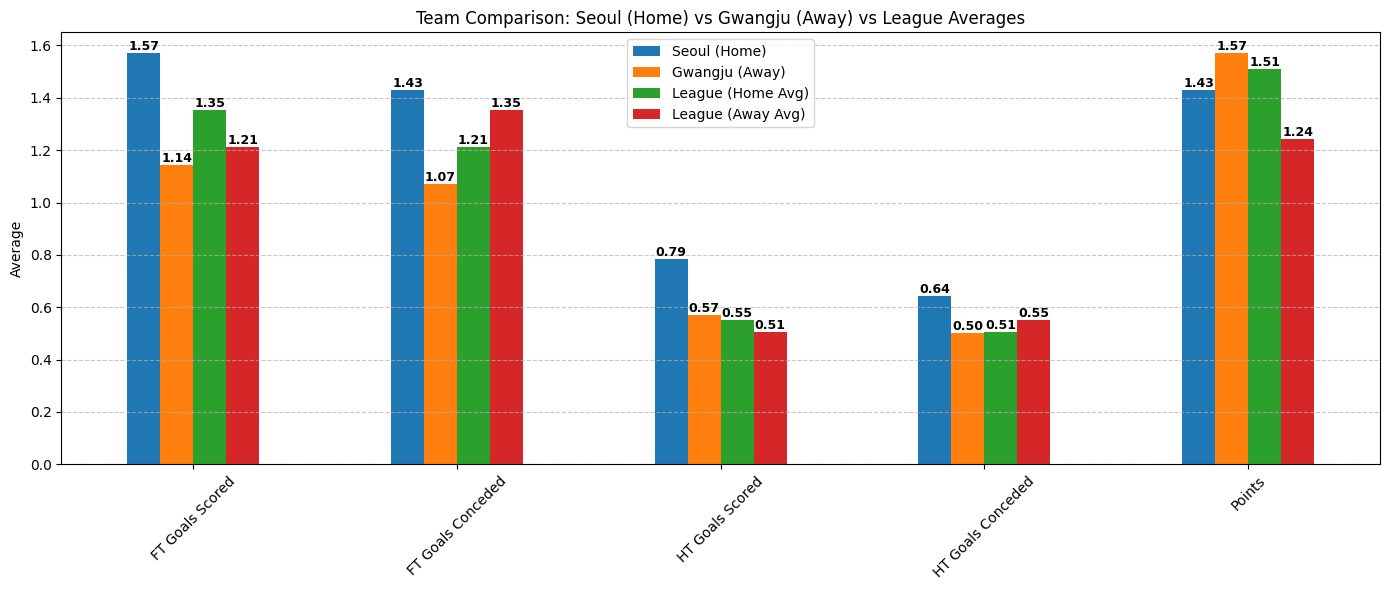

In [3]:
def plot_team_comparison(df, home_team, away_team, leagues):
    stats = {
        "FT Goals Scored": ("FTHG", "FTAG"),
        "FT Goals Conceded": ("FTAG", "FTHG"),
        "HT Goals Scored": ("HTHG", "HTAG"),
        "HT Goals Conceded": ("HTAG", "HTHG"),
        "Points": ("HPS", "APS")
    }

    metrics = []
    labels = []

    for stat_name, (home_col, away_col) in stats.items():
        # Averages for the selected home and away teams
        if len(leagues) > 1:
            home_data = df[(df["Home"] == home_team) & (df['League'] == leagues[0])]
            away_data = df[(df["Away"] == away_team) & (df['League'] == leagues[1])]
        else:
            home_data = df[df["Home"] == home_team]
            away_data = df[df["Away"] == away_team]

        home_avg = home_data[home_col].mean()
        away_avg = away_data[away_col].mean()

        # League averages based on home_col and away_col separately
        league_home_avg = df[home_col].mean()
        league_away_avg = df[away_col].mean()

        metrics.append([home_avg, away_avg, league_home_avg, league_away_avg])
        labels.append(stat_name)

    metrics_df = pd.DataFrame(metrics, 
                              columns=[
                                  f"{home_team} (Home)", 
                                  f"{away_team} (Away)", 
                                  "League (Home Avg)", 
                                  "League (Away Avg)"
                              ], 
                              index=labels)

    ax = metrics_df.plot(kind='bar', figsize=(14, 6))
    plt.ylabel("Average")
    plt.title(f"Team Comparison: {home_team} (Home) vs {away_team} (Away) vs League Averages")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_team_comparison(final, home_team, away_team, uniqe_leagues)

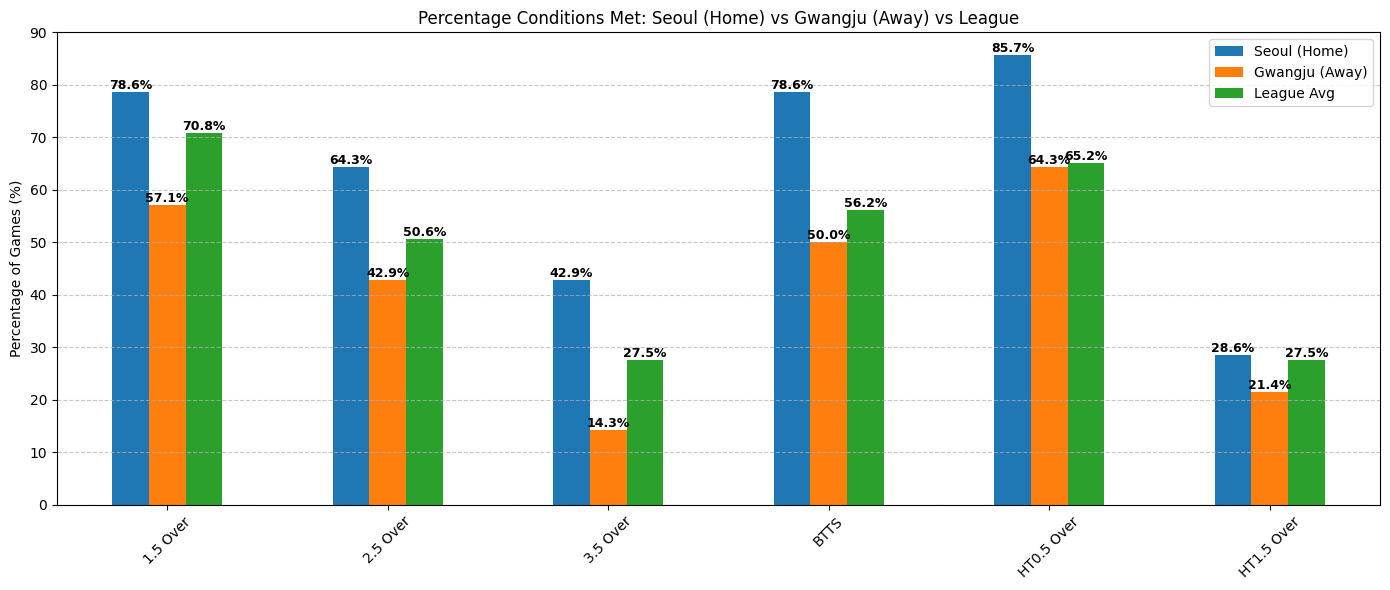

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,HPS,APS
123,Sun 29 Jun,Southkorea,Seoul,Pohang Steelers,4 - 1,(3-0),4,1,5,3,0,3,3,0
130,Sun 20 Jul,Southkorea,Seoul,Ulsan,1 - 0,(1-0),1,0,1,1,0,1,3,0
145,Fri 8 Aug,Southkorea,Seoul,Daegu,2 - 2,(2-1),2,2,4,2,1,3,1,1
161,Sun 24 Aug,Southkorea,Seoul,Ulsan,3 - 2,(3-1),3,2,5,3,1,4,3,0
167,Sun 31 Aug,Southkorea,Seoul,Anyang,1 - 2,(0-1),1,2,3,0,1,1,0,3
121,Sat 28 Jun,Southkorea,Anyang,Gwangju,1 - 2,(1-2),1,2,3,1,2,3,0,3
126,Fri 18 Jul,Southkorea,Suwon City,Gwangju,2 - 1,(0-0),2,1,3,0,0,0,3,0
149,Sun 10 Aug,Southkorea,Pohang Steelers,Gwangju,1 - 0,(1-0),1,0,1,1,0,1,3,0
163,Sat 30 Aug,Southkorea,Jeju Utd,Gwangju,0 - 1,(0-0),0,1,1,0,0,0,0,3
173,Sun 14 Sep,Southkorea,Suwon City,Gwangju,2 - 4,(2-2),2,4,6,2,2,4,0,3


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_team_percentage_stats(df, home_team, away_team, leagues):
    # Define threshold-based conditions
    conditions = {
        "1.5 Over": lambda d: d["FTTG"] > 1.5,
        "2.5 Over": lambda d: d["FTTG"] > 2.5,
        "3.5 Over": lambda d: d["FTTG"] > 3.5,
        "BTTS": lambda d: (d["FTHG"] > 0) & (d["FTAG"] > 0),
        "HT0.5 Over": lambda d: d["HTTG"] > 0.5,
        "HT1.5 Over": lambda d: d["HTTG"] > 1.5
    }

    percentages = []
    labels = []

    for label, condition in conditions.items():
        # Filter data for each team
        if len(leagues) > 1:
            home_data = df[(df["Home"] == home_team) & (df['League'] == leagues[0])]
            away_data = df[(df["Away"] == away_team) & (df['League'] == leagues[1])]
        else:
            home_data = df[df["Home"] == home_team]
            away_data = df[df["Away"] == away_team]

        # Calculate percentage of games that meet the condition
        home_pct = 100 * condition(home_data).mean()
        away_pct = 100 * condition(away_data).mean()

        # League-wide average
        league_pct = 100 * condition(df).mean()

        percentages.append([home_pct, away_pct, league_pct])
        labels.append(label)

    # Create DataFrame for plotting
    percentage_df = pd.DataFrame(percentages,
                                 columns=[
                                     f"{home_team} (Home)", 
                                     f"{away_team} (Away)", 
                                     "League Avg"
                                 ],
                                 index=labels)

    ax = percentage_df.plot(kind='bar', figsize=(14, 6))
    plt.ylabel("Percentage of Games (%)")
    plt.title(f"Percentage Conditions Met: {home_team} (Home) vs {away_team} (Away) vs League")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add data labels
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(f"{height:.1f}%",
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_team_percentage_stats(final, home_team, away_team, uniqe_leagues)

home_data = final[final["Home"] == home_team]
away_data = final[final["Away"] == away_team]
combined = pd.concat([home_data.tail(), away_data.tail()])
combined

In [5]:
def create_points_table(df):
    # Get all unique teams
    teams = pd.concat([df['Home'], df['Away']]).unique()
    
    points_data = []
    
    for team in teams:
        # Home points (when team plays at home)
        home_points = df[df['Home'] == team]['HPS'].sum()
        
        # Away points (when team plays away)
        away_points = df[df['Away'] == team]['APS'].sum()
        
        # Total points
        total_points = home_points + away_points
        
        # Games played
        home_games = len(df[df['Home'] == team])
        away_games = len(df[df['Away'] == team])
        total_games = home_games + away_games
        
        points_data.append({
            'Team': team,
            'Games_Played': total_games,
            'Home_Points': home_points,
            'Away_Points': away_points,
            'Total_Points': total_points,
            'Points_Per_Game': round(total_points / total_games if total_games > 0 else 0, 2)
        })
    
    # Create DataFrame and sort by total points (descending)
    points_table = pd.DataFrame(points_data)
    points_table = points_table.sort_values('Total_Points', ascending=False).reset_index(drop=True)
    points_table['Position'] = points_table.index + 1
    
    # Reorder columns
    points_table = points_table[['Position', 'Team', 'Games_Played', 'Total_Points', 
                                'Home_Points', 'Away_Points', 'Points_Per_Game']]
    
    return points_table

# Create and display the points table
points_table = create_points_table(final)
print("Current League Table:")
points_table

Current League Table:


,Position,Team,Games_Played,Total_Points,Home_Points,Away_Points,Points_Per_Game
0,1,Jeonbuk,30,66,32,34,2.20
1,2,Gimcheon Sangmu,30,49,27,22,1.63
2,3,Daejeon Citizen,30,48,25,23,1.60
3,4,Pohang Steelers,29,45,26,19,1.55
4,5,Gwangju,29,41,19,22,1.41
5,6,Gangwon,30,41,21,20,1.37
6,7,Seoul,29,40,20,20,1.38
7,8,Anyang,30,37,21,16,1.23
8,9,Ulsan,30,36,19,17,1.20
9,10,Suwon City,30,34,24,10,1.13
